In [2]:
import json
import os
import yaml
from pathlib import Path
from dask.distributed import Client

In [3]:
use_local=True

In [4]:
if not use_local:
    with open(f'~/.dlio_profiler/configuration.yaml', 'r') as file:
        dlp_yaml = yaml.safe_load(file)
        app_root = dlp_yaml["app"]
else:
    app_root = str(Path(os.getcwd()).parent.parent)

In [5]:
import sys
sys.path.insert(0, app_root)
sys.path

['/usr/WS2/haridev',
 '/usr/WS2/haridev/scr-dlio/examples',
 '/usr/workspace/iopp/projects/digio',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python39.zip',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9',
 '/collab/usr/gapps/python/build/spack-toss4.1/var/spack/environments/python/._view/75prb56irmif5ejtirjthpx6kq3gqo52/lib/python3.9/lib-dynload',
 '',
 '/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages']

In [6]:
import dlp_analyzer
print(dlp_analyzer.__file__)
from dlp_analyzer.main import DLPAnalyzer,get_dlp_configuration,update_dlp_configuration,setup_logging,setup_dask_cluster, reset_dask_cluster, get_dlp_configuration


/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/__init__.py


In [7]:
if not use_local:
    dask_run_dir = os.path.join(app_root, "dlp_analyzer", "dask", "run_dir")
    with open (os.path.join(dask_run_dir, f"scheduler_{os.getenv('USER')}.json"), "r") as f:
        dask_scheduler = json.load(f)["address"]
else:
    dask_scheduler = None

In [8]:
app_name = "dlio_scr" # dlio dlio_scr

In [9]:
def get_conditions(json_object):
    app_io_cond = "reader" in json_object["cat"] or "checkpoint" in json_object["cat"]
    compute_cond = "compute" in json_object["name"] # Cosmoflow
    io_cond = "POSIX" == json_object["cat"] # Cosmoflow
    return app_io_cond, compute_cond, io_cond

In [10]:
conf = update_dlp_configuration(dask_scheduler=dask_scheduler, verbose=True, workers=64,
                                log_file=f"./dlp_{os.getenv('USER')}.log", rebuild_index=False, time_approximate=True, 
                                host_pattern=r'lassen(\d+)', time_granularity=30e6, skip_hostname=True, conditions=get_conditions)

In [11]:
setup_logging()

In [12]:
setup_dask_cluster()

[INFO] [11:20:34] Initialized Client with 64 workers and link http://127.0.0.1:36087/status [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:668]


In [13]:
def get_checkpoint_time(df):
    app_time = df.query("name.str.contains('PyTorchCheckpointing.checkpoint')")
    app_time_files = app_time.groupby(["pid"]).agg({"dur":sum}).max()
    return app_time_files.compute() / 1e6

def get_posix_pfs_time(df):
    posix_lustre_time = df.query("cat == 'POSIX' and filename.str.contains('/p/lustre2/haridev/dlio/scr/checkpoints')")
    posix_lustre_time_files = posix_lustre_time.groupby(["pid"]).agg({"dur":sum}).max()
    return posix_lustre_time_files.compute() / 1e6

def get_posix_ssd_time(df):
    posix_lustre_time = df.query("cat == 'POSIX' and filename.str.contains('/l/ssd/haridev/scr/checkpoints')")
    posix_lustre_time_files = posix_lustre_time.groupby(["pid"]).agg({"dur":sum}).max()
    return posix_lustre_time_files.compute() / 1e6

In [21]:
# Baseline over PFS
filename = "/g/g92/haridev/projects/scr-dlio/logs/n2_p8_base/trace*.pfw.gz"
analyzer_base_pfs = DLPAnalyzer(filename).events

[INFO] [08:51:16] Created index for 16 files [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:365]
[INFO] [08:51:16] Total size of all files are <dask.bag.core.Item object at 0x1553ebbdafa0> bytes [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:367]
[INFO] [08:51:16] Loading 8994 batches out of 16 files and has 147302750 lines overall [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:380]
[INFO] [08:55:30] Loaded events [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:422]
[INFO] [08:55:30] Loaded plots with slope threshold: 45 [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:428]


In [14]:
base_ckp_time = get_checkpoint_time(analyzer_base_pfs)
base_posix_lustre_time = get_posix_pfs_time(analyzer_base_pfs)
base_posix_ssd_time = get_posix_ssd_time(analyzer_base_pfs)

In [15]:
# Baseline over SSD
filename = "/usr/WS2/haridev/scr-dlio/scripts/hydra_log/megatron_deepspeed/2024-03-21-23-06-04/trace*.pfw.gz"
analyzer_base_ssd = DLPAnalyzer(filename).events

[INFO] [11:25:34] Created index for 16 files [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:365]
[INFO] [11:25:34] Total size of all files are <dask.bag.core.Item object at 0x155446559b80> bytes [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:367]
[INFO] [11:25:34] Loading 8976 batches out of 16 files and has 146988160 lines overall [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:380]
[INFO] [11:29:57] Loaded events [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:422]
[INFO] [11:29:57] Loaded plots with slope threshold: 45 [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:428]


In [16]:
base_ssd_ckp_time = get_checkpoint_time(analyzer_base_ssd)
base_ssd_posix_lustre_time = get_posix_pfs_time(analyzer_base_ssd)
base_ssd_posix_ssd_time = get_posix_ssd_time(analyzer_base_ssd)


In [17]:
# SCR on SSD and with Async Flush to PFS
filename = "/g/g92/haridev/projects/scr-dlio/logs/n2_p8_scr_finer/trace*.pfw.gz"
analyzer_scr_basic = DLPAnalyzer(filename).events

[INFO] [17:33:53] Created index for 16 files [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:365]
[INFO] [17:33:53] Total size of all files are <dask.bag.core.Item object at 0x1551700ada00> bytes [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:367]
[INFO] [17:33:54] Loading 9132 batches out of 16 files and has 149432067 lines overall [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:380]
[INFO] [17:38:32] Loaded events [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:422]
[INFO] [17:38:32] Loaded plots with slope threshold: 45 [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:428]


In [18]:
scr_ssd_async_pfs_ckp_time = get_checkpoint_time(analyzer_scr_basic)
scr_ssd_async_pfs_posix_lustre_time = get_posix_pfs_time(analyzer_scr_basic)
scr_ssd_async_pfs_posix_ssd_time = get_posix_ssd_time(analyzer_scr_basic)


In [14]:
# SCR on SSD and no flush
filename = "/usr/WS2/haridev/scr-dlio/scripts/hydra_log/scr_megatron_deepspeed/2024-03-20-10-52-41/trace*.pfw.gz"
analyzer_scr_no_flush = DLPAnalyzer(filename).events

[INFO] [11:20:44] Created index for 16 files [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:365]
[INFO] [11:20:44] Total size of all files are <dask.bag.core.Item object at 0x155446c83a00> bytes [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:367]
[INFO] [11:20:46] Loading 9124 batches out of 16 files and has 149369304 lines overall [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:380]
[INFO] [11:25:33] Loaded events [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:422]
[INFO] [11:25:33] Loaded plots with slope threshold: 45 [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:428]


In [20]:

scr_ssd_no_flush_ckp_time = get_checkpoint_time(analyzer_scr_no_flush)
scr_ssd_no_flush_posix_lustre_time = get_posix_pfs_time(analyzer_scr_no_flush)
scr_ssd_no_flush_posix_ssd_time = get_posix_ssd_time(analyzer_scr_no_flush)

In [21]:
# SCR bypass
filename = "/usr/WS2/haridev/scr-dlio/scripts/hydra_log/scr_megatron_deepspeed/2024-03-21-22-44-18/trace*.pfw.gz"
analyzer_scr_bypass = DLPAnalyzer(filename).events

[INFO] [17:44:50] Created index for 16 files [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:365]
[INFO] [17:44:50] Total size of all files are <dask.bag.core.Item object at 0x15515cf35a00> bytes [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:367]
[INFO] [17:44:50] Loading 8977 batches out of 16 files and has 146963672 lines overall [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:380]
[INFO] [17:50:37] Loaded events [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:422]
[INFO] [17:50:37] Loaded plots with slope threshold: 45 [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:428]


In [22]:

scr_bypass_ckp_time = get_checkpoint_time(analyzer_scr_bypass)
scr_bypass_posix_lustre_time = get_posix_pfs_time(analyzer_scr_bypass)
scr_bypass_posix_ssd_time = get_posix_ssd_time(analyzer_scr_bypass)

In [23]:
# SCR ssd single copy
filename = "/usr/WS2/haridev/scr-dlio/scripts/hydra_log/scr_megatron_deepspeed/2024-04-08-09-33-09/trace*.pfw.gz"
analyzer_scr_ssd_single = DLPAnalyzer(filename).events

[INFO] [17:50:47] Created index for 8 files [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:365]
[INFO] [17:50:47] Total size of all files are <dask.bag.core.Item object at 0x15529cfa3310> bytes [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:367]
[INFO] [17:50:47] Loading 4488 batches out of 8 files and has 73467844 lines overall [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:380]
[INFO] [17:53:12] Loaded events [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:422]
[INFO] [17:53:12] Loaded plots with slope threshold: 45 [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:428]


In [24]:

scr_ssd_single_ckp_time = get_checkpoint_time(analyzer_scr_ssd_single)
scr_ssd_single_posix_lustre_time = get_posix_pfs_time(analyzer_scr_ssd_single)
scr_ssd_single_posix_ssd_time = get_posix_ssd_time(analyzer_scr_ssd_single)

In [13]:
# SCR pfs single copy
filename = "/usr/WS2/haridev/scr-dlio/scripts/hydra_log/scr_megatron_deepspeed/2024-04-08-10-52-57/trace*.pfw.gz"
analyzer_scr_pfs_single = DLPAnalyzer(filename).events

[INFO] [08:44:09] Created index for 16 files [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:365]
[INFO] [08:44:09] Total size of all files are <dask.bag.core.Item object at 0x1554ea273640> bytes [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:367]
[INFO] [08:44:10] Loading 8986 batches out of 16 files and has 147099195 lines overall [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:380]
ERROR:root:Processing {"id":"6930","name":"close","cat":"POSIX","pid":"0","tid":"953748","ts":"1712599257392616","dur":"4012","ph":"X","args":{"hostname":"corona171","ret":0,"fname":"","fd":39}} failed with Invalid control character at: line 1 column 162 (char 161)
[INFO] [08:48:23] Loaded events [/usr/workspace/haridev/scr-dlio/venv/lib/python3.9/site-packages/dlp_analyzer/main.py:422]
[INFO] [08:48:23] Loaded plots with slope threshold: 45 [/usr/workspace/haridev/scr-dlio/venv/lib/pytho

In [26]:

scr_pfs_single_ckp_time = get_checkpoint_time(analyzer_scr_pfs_single)
scr_pfs_single_posix_lustre_time = get_posix_pfs_time(analyzer_scr_pfs_single)
scr_pfs_single_posix_ssd_time = get_posix_ssd_time(analyzer_scr_pfs_single)

In [29]:
scr_pfs_single_ckp_time, scr_pfs_single_posix_lustre_time, scr_pfs_single_posix_ssd_time

(dur    167.23401
 dtype: double[pyarrow],
 dur    1060.07277
 dtype: double[pyarrow],
 dur    472.086514
 dtype: double[pyarrow])

In [32]:
print(f"{str('case'):20}, {str('base'):15}, {str('base_ssd'):15}, {str('scr_ssd_a_pfs'):15}, {str('scr_ssd_nf'):15}, {str('scr_bypass'):15}, {str('scr_ssd_nf_one'):15}, {str('scr_pfs_one'):15}")
print(f"{str('checkpoint time'):20}, {float(base_ckp_time):15}, {float(base_ssd_ckp_time):15}, {float(scr_ssd_async_pfs_ckp_time):15}, {float(scr_ssd_no_flush_ckp_time):15}, {float(scr_bypass_ckp_time):15}, {float(scr_ssd_single_ckp_time):15}, {float(scr_pfs_single_ckp_time):15}")
print(f"{str('lustre time'):20}, {float(base_posix_lustre_time):15}, {0:15}, {float(scr_ssd_async_pfs_posix_lustre_time):15}, {float(scr_ssd_no_flush_posix_lustre_time):15}, {float(scr_bypass_posix_lustre_time):15}, {float(0):15}, {float(scr_pfs_single_posix_lustre_time):15}")
print(f"{str('ssd time'):20}, {0:15}, {float(base_ssd_posix_ssd_time):15}, {float(scr_ssd_async_pfs_posix_ssd_time):15}, {float(scr_ssd_no_flush_posix_ssd_time):15}, {float(scr_bypass_posix_ssd_time):15}, {float(scr_ssd_single_posix_ssd_time):15}, {float(scr_pfs_single_posix_ssd_time):15}")

case                , base           , base_ssd       , scr_ssd_a_pfs  , scr_ssd_nf     , scr_bypass     , scr_ssd_nf_one , scr_pfs_one    
checkpoint time     ,      103.057664,      126.296083,      378.215081,      349.139191,      145.122746,      153.369808,       167.23401
lustre time         ,        72.63898,               0,     1471.540838,       19.608824,       118.42119,             0.0,      1060.07277
ssd time            ,               0,       97.497736,      837.766052,      308.222378,        0.152704,      121.076746,      472.086514


### Things to try (3/27/24)
- Remove redundancy schemes: SCR_COPY_TYPE=SINGLE
  - (Potentially) Less frequent reduncy schemes:


### Things to try (4/17/24)
- Compare Base SSD with SCR SSD no flush
  - Check size
  - Check files

In [26]:
base_ssd_checkpoints = analyzer_base_ssd.query("cat == 'POSIX' and filename.str.contains('/l/ssd/haridev/scr/checkpoints')").compute()
base_ssd_checkpoints["size"].sum()/1024**3


577.07171420753

In [27]:
scr_ssd_nf_checkpoints = analyzer_scr_no_flush.query("cat == 'POSIX' and filename.str.contains('/l/ssd/haridev/scr/checkpoints')").compute()
scr_ssd_nf_checkpoints["size"].sum()/1024**3

2019.7582258917391

In [34]:
import pandas as pd
def print_full():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [53]:
print_full(1000)
import re
base_ssd_checkpoints.groupby(["filename"])["size"].sum()
base_ssd_checkpoints["fname"] = base_ssd_checkpoints["filename"].apply(lambda x: str(os.path.basename(x)))
base_ssd_checkpoints["fname_regex"] = base_ssd_checkpoints["fname"].apply(lambda x: re.sub("[\d\-]+", "", x))
base_ssd_checkpoints["size_gb"] = base_ssd_checkpoints["size"] / 1024 ** 3
base_ssd_checkpoints["dur_sec"] = base_ssd_checkpoints["dur"] / 1e6
base_ssd_checkpoints.groupby(["fname_regex", "pid"])[["size_gb","dur_sec"]].sum().groupby(["fname_regex"]).max()

1000


,size_gb,dur_sec
fname_regex,,
layer.pt,37.060777,39.932368
model.pt,0.000172,0.027605
optimizer.pt,31.434213,68.512567
scr_base_megatron_deepspeed,0.0,0.000025


In [55]:
print_full(1000)
scr_ssd_nf_checkpoints.groupby(["filename"])["size"].sum()
scr_ssd_nf_checkpoints["fname"] = scr_ssd_nf_checkpoints["filename"].apply(lambda x: str(os.path.basename(x)))
scr_ssd_nf_checkpoints["fname_regex"] = scr_ssd_nf_checkpoints["fname"].apply(lambda x: re.sub("[\d\-]+", "", x))
scr_ssd_nf_checkpoints["size_gb"] = scr_ssd_nf_checkpoints["size"] / 1024 ** 3
scr_ssd_nf_checkpoints["dur_sec"] = scr_ssd_nf_checkpoints["dur"] / 1e6
scr_ssd_nf_checkpoints.groupby(["fname_regex", "pid"])[["size_gb","dur_sec"]].sum().groupby(["fname_regex"]).max()

1000


,size_gb,dur_sec
fname_regex,,
.scr,0.0,0.000174
filemap_,0.002691,20.046874
haridev,0.0,0.00003
layer.pt,86.475146,53.715143
model.pt,0.000402,0.007508
optimizer.pt,73.346496,99.128509
reddesc.er..redset,0.000002,0.363602
reddesc.er..xor.grp__of_.mem__of_.redset,79.911251,139.56437
reddesc.er.er,0.000001,0.323558


In [92]:
base_ssd_checkpoints.query("fname.str.contains('model')")["fname_regex"].nunique(), \
    base_ssd_checkpoints.query("fname.str.contains('model')")["fname_regex"].count(), \
base_ssd_checkpoints.query("fname.str.contains('model')")["size"].mean() / 1024, \
    base_ssd_checkpoints.query("fname.str.contains('model') and size > 0")["fname_regex"].count(), \
    base_ssd_checkpoints.query("fname.str.contains('model') and name.str.contains('write')")["fname_regex"].count(), \
    base_ssd_checkpoints.query("fname.str.contains('model') and name.str.contains('read')")["fname_regex"].count()

(1, 672, 10.034830729166666, 288, 288, 0)

In [89]:
base_ssd_checkpoints.query("fname.str.contains('model') and size > 0")["size"].value_counts()

size
320      96
30102    96
405      96
Name: count, dtype: int64[pyarrow]

In [91]:
scr_ssd_nf_checkpoints.query("fname.str.contains('model')")["fname_regex"].nunique(), \
scr_ssd_nf_checkpoints.query("fname.str.contains('model')")["fname_regex"].count(), \
scr_ssd_nf_checkpoints.query("fname.str.contains('model')")["size"].mean() / 1024, \
    scr_ssd_nf_checkpoints.query("fname.str.contains('model') and size > 0")["fname_regex"].count(), \
    scr_ssd_nf_checkpoints.query("fname.str.contains('model') and name.str.contains('write')")["fname_regex"].count(), \
    scr_ssd_nf_checkpoints.query("fname.str.contains('model') and name.str.contains('read')")["fname_regex"].count()
        

(1, 87842, 16.210111177884617, 416, 304, 112)

In [88]:
scr_ssd_nf_checkpoints.query("fname.str.contains('model') and size > 0")["size"].value_counts()

size
30827    128
320       96
30102     96
405       96
Name: count, dtype: int64[pyarrow]

In [98]:
scr_ssd_nf_checkpoints.query("fname.str.contains('model') and size == 30827 and name == 'write'")["fname"].value_counts()

fname
model-1-600-0.pt     1
model-1-600-10.pt    1
model-1-600-11.pt    1
model-1-600-12.pt    1
model-1-600-13.pt    1
model-1-600-14.pt    1
model-1-600-15.pt    1
model-1-600-1.pt     1
model-1-600-2.pt     1
model-1-600-3.pt     1
model-1-600-4.pt     1
model-1-600-5.pt     1
model-1-600-6.pt     1
model-1-600-7.pt     1
model-1-600-8.pt     1
model-1-600-9.pt     1
Name: count, dtype: int64

In [99]:
scr_ssd_nf_checkpoints.query("fname.str.contains('model') and size == 30827 and name == 'read'")["fname"].value_counts()

fname
model-1-600-0.pt     2
model-1-600-12.pt    2
model-1-600-9.pt     2
model-1-600-8.pt     2
model-1-600-7.pt     2
                    ..
model-1-500-15.pt    1
model-1-400-15.pt    1
model-1-300-15.pt    1
model-1-200-15.pt    1
model-1-500-9.pt     1
Name: count, Length: 96, dtype: int64

In [100]:
scr_ssd_nf_checkpoints.query("fname.str.contains('model-1-600') and size == 30827 and name == 'read'")["fname"].value_counts()

fname
model-1-600-0.pt     2
model-1-600-10.pt    2
model-1-600-11.pt    2
model-1-600-12.pt    2
model-1-600-13.pt    2
model-1-600-14.pt    2
model-1-600-15.pt    2
model-1-600-1.pt     2
model-1-600-2.pt     2
model-1-600-3.pt     2
model-1-600-4.pt     2
model-1-600-5.pt     2
model-1-600-6.pt     2
model-1-600-7.pt     2
model-1-600-8.pt     2
model-1-600-9.pt     2
Name: count, dtype: int64

In [101]:
scr_ssd_nf_checkpoints.query("~fname.str.contains('model-1-600') and size == 30827 and name == 'read'")["fname"].value_counts()

fname
model-1-100-0.pt     1
model-1-200-0.pt     1
model-1-400-5.pt     1
model-1-300-5.pt     1
model-1-200-5.pt     1
                    ..
model-1-100-14.pt    1
model-1-500-13.pt    1
model-1-400-13.pt    1
model-1-300-13.pt    1
model-1-500-9.pt     1
Name: count, Length: 80, dtype: int64

30.894138889191026
30.894138889191026
0    POSIX
1    STDIO
Name: cat, dtype: string


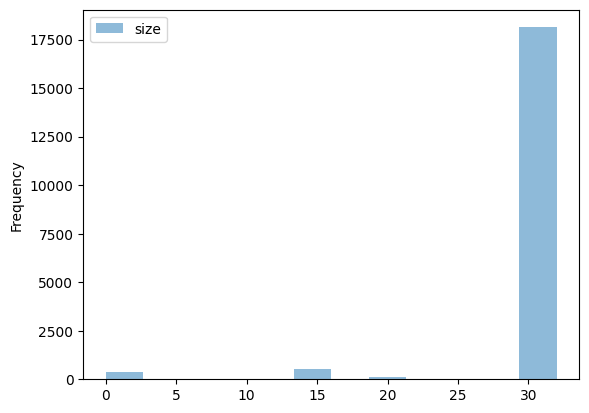

In [40]:
# SCR
posix_lustre_time = analyzer_scr_pfs_single.query("cat == 'POSIX' and filename.str.contains('/p/lustre2/haridev/dlio/scr/checkpoints')")
print(posix_lustre_time["size"].mean().compute() / 1024**2)
posix_lustre_time = analyzer_scr_pfs_single.query("filename.str.contains('/p/lustre2/haridev/dlio/scr/checkpoints')")
print(posix_lustre_time["size"].mean().compute() / 1024**2)
posix_lustre_time = analyzer_scr_pfs_single.query("filename.str.contains('/p/lustre2/haridev/dlio/scr/checkpoints')")
print(posix_lustre_time["cat"].unique().compute())
val = posix_lustre_time[["size"]].compute() / 1024**2
ax = val.plot.hist(bins=12, alpha=0.5)

In [51]:
analyzer_scr_no_flush.query("cat == 'POSIX' and filename.str.contains('/l/ssd/haridev/scr/checkpoints')")["size"].sum().compute() /1024**3

NameError: name 'analyzer_scr_no_flush' is not defined

In [49]:
analyzer_scr_pfs_single.query("cat == 'POSIX' and filename.str.contains('/l/ssd/haridev/scr/checkpoints')")["filename"].unique().compute()

0       /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
1       /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
2       /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
3       /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
4       /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
                              ...                        
2277    /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
2278    /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
2279    /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
2280    /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
2281    /l/ssd/haridev/scr/checkpoints/scr_megatron_de...
Name: filename, Length: 2282, dtype: string

In [46]:
analyzer_base_ssd.query("cat == 'POSIX' and filename.str.contains('/l/ssd/haridev/scr/checkpoints')")["size"].sum().compute() /1024**3

577.07171420753

In [50]:
analyzer_base_ssd.query("cat == 'POSIX' and filename.str.contains('/l/ssd/haridev/scr/checkpoints')")["filename"].unique().compute()

0      /l/ssd/haridev/scr/checkpoints/scr_base_megatr...
1      /l/ssd/haridev/scr/checkpoints/scr_base_megatr...
2      /l/ssd/haridev/scr/checkpoints/scr_base_megatr...
3      /l/ssd/haridev/scr/checkpoints/scr_base_megatr...
4      /l/ssd/haridev/scr/checkpoints/scr_base_megatr...
                             ...                        
716    /l/ssd/haridev/scr/checkpoints/scr_base_megatr...
717    /l/ssd/haridev/scr/checkpoints/scr_base_megatr...
718    /l/ssd/haridev/scr/checkpoints/scr_base_megatr...
719    /l/ssd/haridev/scr/checkpoints/scr_base_megatr...
720    /l/ssd/haridev/scr/checkpoints/scr_base_megatr...
Name: filename, Length: 721, dtype: string

155.8337118535102
155.8337118535102
0    POSIX
Name: cat, dtype: string


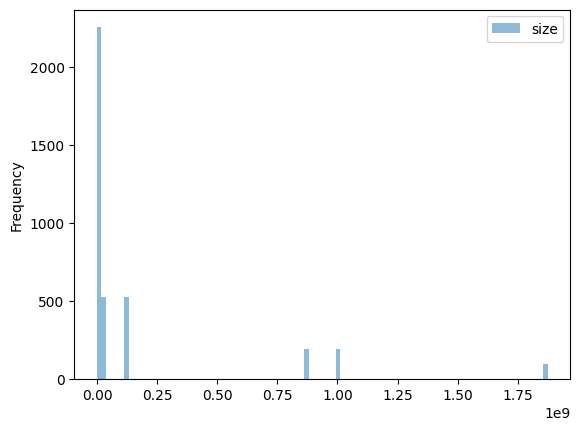

In [32]:
# Base with PFS
posix_lustre_time = analyzer_base_pfs.query("cat == 'POSIX' and filename.str.contains('/p/lustre2/haridev/dlio/scr/checkpoints')")
print(posix_lustre_time["size"].mean().compute() / 1024**2)
posix_lustre_time = analyzer_base_pfs.query("filename.str.contains('/p/lustre2/haridev/dlio/scr/checkpoints')")
print(posix_lustre_time["size"].mean().compute() / 1024**2)
posix_lustre_time = analyzer_base_pfs.query("filename.str.contains('/p/lustre2/haridev/dlio/scr/checkpoints')")
print(posix_lustre_time["cat"].unique().compute())
ax = posix_lustre_time.plot.hist(bins=100, alpha=0.5)

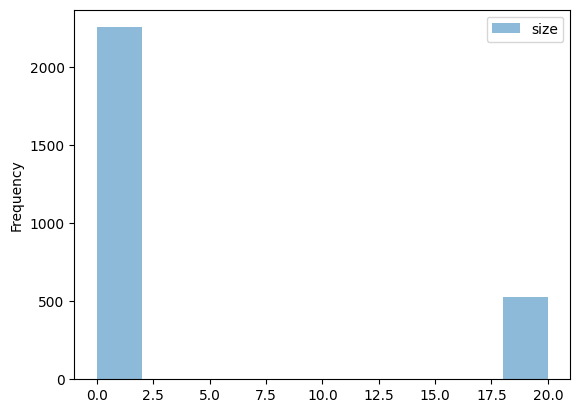

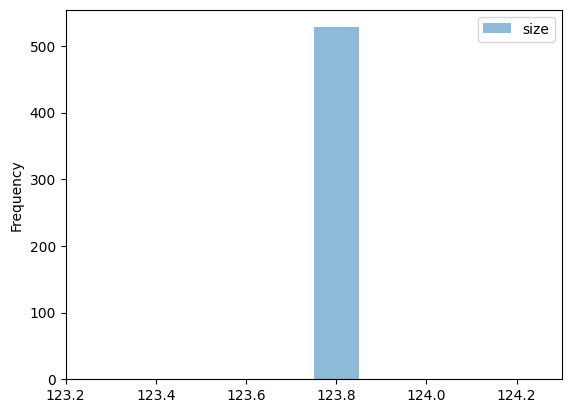

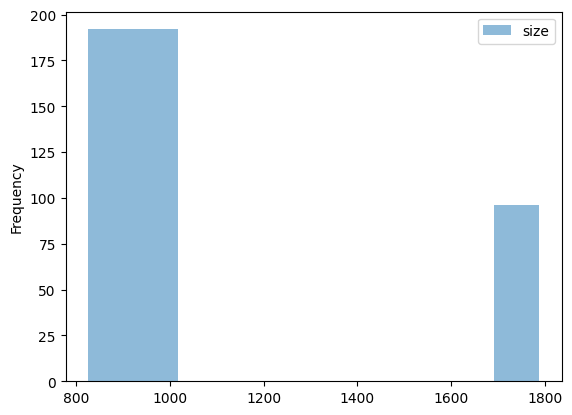

In [37]:
val = posix_lustre_time[["size"]].compute()
val_100mb = val.query("size < 104857600")/ 1024**2
val_mb = val.query("size >= 104857600 and size < 419430400") / 1024**2
val_gb = val.query("size >= 419430400")/ 1024**2
ax = val_100mb.plot.hist(bins=10, alpha=0.5)
ax = val_mb.plot.hist(bins=10, alpha=0.5)
ax = val_gb.plot.hist(bins=10, alpha=0.5)

In [24]:
# Base with SSD
posix_lustre_time = analyzer_base_ssd.query("cat == 'POSIX' and filename.str.contains('/l/ssd/haridev/scr/checkpoints')")
posix_lustre_time["size"].mean().compute() / 1024**2

135.28421138931105